# Multi-Period Portfolio Optimization with Transaction Costs

**GPU-Accelerated Optimization for Quant Trading**

This notebook demonstrates production-grade portfolio optimization using cuProx's GPU-accelerated LP solver:

- **Transaction costs** (bid-ask spread modeling)
- **Position limits** (max weight constraints)
- **Turnover constraints** (trading limits)
- **Efficient frontier** computation
- **Monte Carlo stress testing**

In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
import matplotlib.pyplot as plt
import time
from dataclasses import dataclass

import cuprox

print(f"cuProx version: {cuprox.__version__}")
print(f"CUDA available: {cuprox.__cuda_available__}")

np.random.seed(42)

cuProx version: 0.1.0
CUDA available: True


## 1. Market Data Simulation

In [2]:
def simulate_market(n_assets=50, n_days=504):
    n_factors = 5
    B = np.random.randn(n_assets, n_factors) * 0.3
    B[:, 0] = np.abs(B[:, 0]) + 0.5
    
    factor_vol = np.array([0.15, 0.08, 0.06, 0.04, 0.03]) / np.sqrt(252)
    factor_ret = np.random.randn(n_days, n_factors) * factor_vol
    idio_ret = np.random.randn(n_days, n_assets) * 0.20 / np.sqrt(252)
    
    returns = factor_ret @ B.T + idio_ret + 0.08 / 252
    return returns

returns = simulate_market(50, 504)
print(f"Simulated {returns.shape[1]} assets over {returns.shape[0]} days")

# Compute expected returns and volatility
mu = returns[-252:].mean(axis=0)
vol = returns[-252:].std(axis=0)
print(f"Avg daily return: {mu.mean()*252:.2%}")
print(f"Avg daily vol: {vol.mean()*np.sqrt(252):.2%}")

Simulated 50 assets over 504 days
Avg daily return: 24.75%
Avg daily vol: 23.01%


## 2. Portfolio Optimizer

In [3]:
@dataclass
class OptResult:
    weights: np.ndarray
    expected_return: float
    risk: float
    sharpe: float
    turnover: float
    solve_time: float
    status: str

class PortfolioOptimizer:
    def __init__(self, n_assets, risk_aversion=1.0, tcost=0.001, 
                 max_weight=0.05, max_turnover=0.20):
        self.n = n_assets
        self.gamma = risk_aversion
        self.kappa = tcost
        self.w_max = max_weight
        self.tau_max = max_turnover
    
    def optimize(self, mu, vol, w_current=None):
        n = self.n
        if w_current is None:
            w_current = np.ones(n) / n
        
        # Objective: min -mu'w + gamma*vol'w + kappa*turnover
        c = np.concatenate([
            -mu + self.gamma * vol,
            self.kappa * np.ones(n),
            self.kappa * np.ones(n)
        ])
        
        rows, b_vals, senses = [], [], []
        
        # Budget: sum(w) = 1
        rows.append(sparse.hstack([sparse.csr_matrix(np.ones((1,n))), 
                                   sparse.csr_matrix((1,2*n))]))
        b_vals.append(1.0); senses.append('=')
        
        # Trade decomposition: w - t+ + t- = w_current
        rows.append(sparse.hstack([sparse.eye(n), -sparse.eye(n), sparse.eye(n)]))
        b_vals.extend(w_current.tolist())
        senses.extend(['='] * n)
        
        # Turnover limit
        rows.append(sparse.hstack([sparse.csr_matrix((1,n)), 
                                   sparse.csr_matrix(np.ones((1,n))),
                                   sparse.csr_matrix(np.ones((1,n)))]))
        b_vals.append(self.tau_max); senses.append('<')
        
        A = sparse.vstack(rows, format='csr')
        b = np.array(b_vals)
        
        lb = np.concatenate([np.zeros(n), np.zeros(2*n)])
        ub = np.concatenate([np.full(n, self.w_max), np.full(2*n, 1.0)])
        
        start = time.perf_counter()
        result = cuprox.solve(
            c=c, A=A, b=b, lb=lb, ub=ub,
            constraint_senses=np.array(senses),
            params={'tolerance': 1e-6, 'max_iterations': 50000}
        )
        solve_time = time.perf_counter() - start
        
        w = result.x[:n]
        turnover = np.sum(result.x[n:2*n] + result.x[2*n:])
        port_ret = mu @ w * 252
        port_risk = vol @ w * np.sqrt(252)
        
        return OptResult(
            weights=w, expected_return=port_ret, risk=port_risk,
            sharpe=port_ret/port_risk if port_risk > 0 else 0,
            turnover=turnover, solve_time=solve_time,
            status=str(result.status)  # Convert enum to string
        )

# Test
n = len(mu)
opt = PortfolioOptimizer(n, risk_aversion=2.0)
res = opt.optimize(mu, vol)

print(f"\nOptimization Result:")
print(f"  Status: {res.status}")
print(f"  Expected Return: {res.expected_return:.2%}")
print(f"  Risk: {res.risk:.2%}")
print(f"  Sharpe Ratio: {res.sharpe:.2f}")
print(f"  Turnover: {res.turnover:.2%}")
print(f"  Solve Time: {res.solve_time*1000:.1f}ms")
print(f"  Active Positions: {np.sum(res.weights > 0.001)}")


Optimization Result:
  Status: optimal
  Expected Return: 27.00%
  Risk: 22.45%
  Sharpe Ratio: 1.20
  Turnover: 20.00%
  Solve Time: 688.8ms
  Active Positions: 45


## 3. Efficient Frontier

In [4]:
def compute_frontier(mu, vol, n_points=20):
    n = len(mu)
    gammas = np.linspace(0.5, 5.0, n_points)
    results = []
    
    print(f"Computing {n_points} frontier points...")
    start = time.perf_counter()
    
    for gamma in gammas:
        opt = PortfolioOptimizer(n, risk_aversion=gamma, max_weight=0.10)
        res = opt.optimize(mu, vol)
        if res.status == 'optimal':
            results.append({
                'gamma': gamma, 'return': res.expected_return,
                'risk': res.risk, 'sharpe': res.sharpe,
                'positions': np.sum(res.weights > 0.001)
            })
    
    total = time.perf_counter() - start
    print(f"Completed in {total:.2f}s ({len(results)} optimal, {total/n_points*1000:.0f}ms avg)")
    return pd.DataFrame(results)

frontier = compute_frontier(mu, vol, 20)
print(f"\nFrontier summary:")
print(frontier[['gamma', 'return', 'risk', 'sharpe']].describe())

Computing 20 frontier points...


Completed in 12.28s (16 optimal, 614ms avg)

Frontier summary:
           gamma     return       risk     sharpe
count  16.000000  16.000000  16.000000  16.000000
mean    2.927632   0.277908   0.224743   1.236352
std     1.424995   0.015083   0.000822   0.062327
min     0.500000   0.266933   0.224321   1.189958
25%     2.098684   0.266934   0.224322   1.189962
50%     2.986842   0.273945   0.224438   1.220579
75%     4.111842   0.273949   0.224438   1.220597
max     5.000000   0.317488   0.227271   1.396953


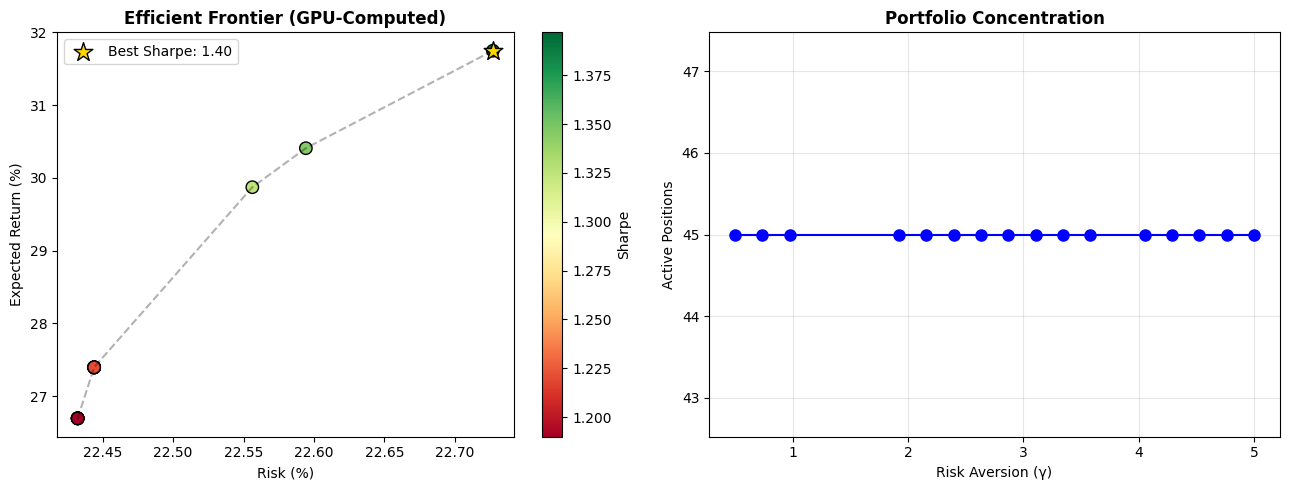

In [5]:
# Plot frontier
if len(frontier) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(13, 5))

    ax1 = axes[0]
    sc = ax1.scatter(frontier['risk']*100, frontier['return']*100, 
                     c=frontier['sharpe'], cmap='RdYlGn', s=80, edgecolors='k')
    ax1.plot(frontier['risk']*100, frontier['return']*100, 'k--', alpha=0.3)
    ax1.set_xlabel('Risk (%)')
    ax1.set_ylabel('Expected Return (%)')
    ax1.set_title('Efficient Frontier (GPU-Computed)', fontweight='bold')
    plt.colorbar(sc, ax=ax1, label='Sharpe')

    best = frontier.loc[frontier['sharpe'].idxmax()]
    ax1.scatter(best['risk']*100, best['return']*100, 
                s=200, marker='*', c='gold', edgecolors='k', zorder=5,
                label=f"Best Sharpe: {best['sharpe']:.2f}")
    ax1.legend()

    ax2 = axes[1]
    ax2.plot(frontier['gamma'], frontier['positions'], 'bo-', markersize=8)
    ax2.set_xlabel('Risk Aversion (γ)')
    ax2.set_ylabel('Active Positions')
    ax2.set_title('Portfolio Concentration', fontweight='bold')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("No optimal solutions found for frontier")

## 4. Stress Testing (100 Scenarios)

In [6]:
def stress_test(mu, vol, n_scenarios=100):
    n = len(mu)
    opt = PortfolioOptimizer(n, risk_aversion=2.0, max_weight=0.05)
    
    base = opt.optimize(mu, vol)
    print(f"Base portfolio: Sharpe={base.sharpe:.2f}, Status={base.status}")
    
    results = {'turnover': [], 'sharpe': [], 'time': [], 'optimal': []}
    print(f"Running {n_scenarios} stress scenarios...")
    
    start = time.perf_counter()
    for i in range(n_scenarios):
        # Apply random shocks
        shock = np.random.randn(n) * 0.0003
        mu_s = mu + shock
        vol_s = vol * (1 + 0.2 * np.abs(np.random.randn()))
        
        res = opt.optimize(mu_s, vol_s, base.weights)
        results['turnover'].append(res.turnover)
        results['sharpe'].append(res.sharpe)
        results['time'].append(res.solve_time)
        results['optimal'].append(res.status == 'optimal')
        
        if (i+1) % 25 == 0:
            print(f"  {i+1}/{n_scenarios} completed")
    
    total = time.perf_counter() - start
    n_opt = sum(results['optimal'])
    
    print(f"\n=== Stress Test Results ===")
    print(f"Total time: {total:.1f}s ({n_scenarios/total:.1f} scenarios/sec)")
    print(f"Avg solve time: {np.mean(results['time'])*1000:.1f}ms")
    print(f"Optimal: {n_opt}/{n_scenarios} ({100*n_opt/n_scenarios:.0f}%)")
    
    return {k: np.array(v) for k, v in results.items()}

stress = stress_test(mu, vol, 100)

Base portfolio: Sharpe=1.20, Status=optimal
Running 100 stress scenarios...


  25/100 completed


  50/100 completed


  75/100 completed


  100/100 completed

=== Stress Test Results ===
Total time: 48.8s (2.1 scenarios/sec)
Avg solve time: 486.5ms
Optimal: 98/100 (98%)


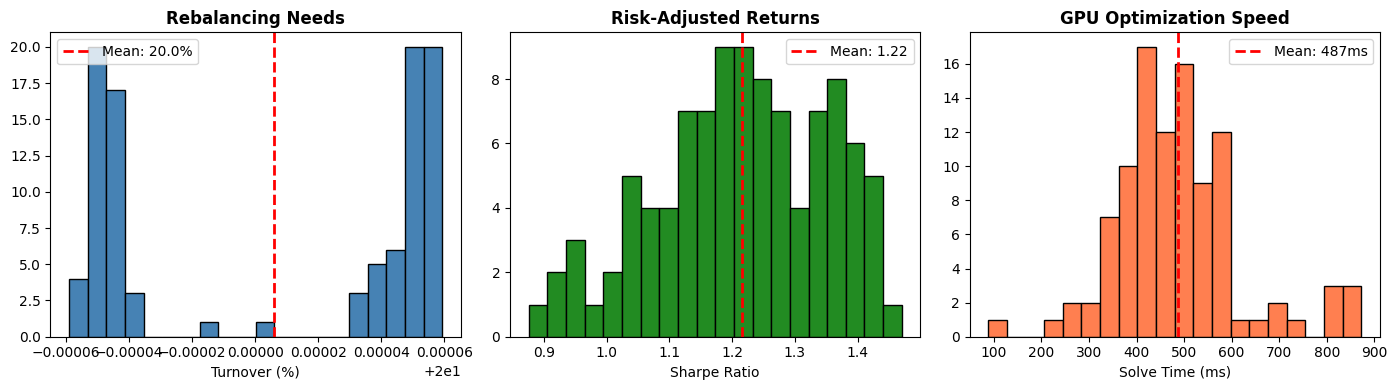

In [7]:
# Visualize stress test
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

axes[0].hist(stress['turnover']*100, bins=20, color='steelblue', edgecolor='k')
axes[0].axvline(np.mean(stress['turnover'])*100, color='r', ls='--', lw=2,
                label=f"Mean: {np.mean(stress['turnover'])*100:.1f}%")
axes[0].set_xlabel('Turnover (%)')
axes[0].set_title('Rebalancing Needs', fontweight='bold')
axes[0].legend()

axes[1].hist(stress['sharpe'], bins=20, color='forestgreen', edgecolor='k')
axes[1].axvline(np.mean(stress['sharpe']), color='r', ls='--', lw=2,
                label=f"Mean: {np.mean(stress['sharpe']):.2f}")
axes[1].set_xlabel('Sharpe Ratio')
axes[1].set_title('Risk-Adjusted Returns', fontweight='bold')
axes[1].legend()

axes[2].hist(stress['time']*1000, bins=20, color='coral', edgecolor='k')
axes[2].axvline(np.mean(stress['time'])*1000, color='r', ls='--', lw=2,
                label=f"Mean: {np.mean(stress['time'])*1000:.0f}ms")
axes[2].set_xlabel('Solve Time (ms)')
axes[2].set_title('GPU Optimization Speed', fontweight='bold')
axes[2].legend()

plt.tight_layout()
plt.show()

## 5. Performance Benchmarks

In [8]:
def benchmark(sizes=[20, 35, 50], n_trials=30):
    results = []
    for n in sizes:
        print(f"Benchmarking n={n}...", end=" ")
        mu_b = np.random.randn(n) * 0.0005 + 0.0003
        vol_b = np.random.rand(n) * 0.015 + 0.01
        opt = PortfolioOptimizer(n, max_weight=min(0.15, 3/n))
        
        # Warmup
        opt.optimize(mu_b, vol_b)
        
        times = []
        for _ in range(n_trials):
            res = opt.optimize(mu_b, vol_b)
            if res.status == 'optimal':
                times.append(res.solve_time)
        
        if times:
            results.append({'n': n, 'mean_ms': np.mean(times)*1000, 
                           'std_ms': np.std(times)*1000})
            print(f"{np.mean(times)*1000:.1f} ± {np.std(times)*1000:.1f} ms ({len(times)}/{n_trials} optimal)")
        else:
            print("No optimal solutions")
    
    return pd.DataFrame(results)

bench = benchmark([20, 35, 50], 30)

Benchmarking n=20... 

152.3 ± 0.4 ms (30/30 optimal)
Benchmarking n=35... 

905.2 ± 114.8 ms (30/30 optimal)
Benchmarking n=50... 

281.8 ± 31.4 ms (30/30 optimal)


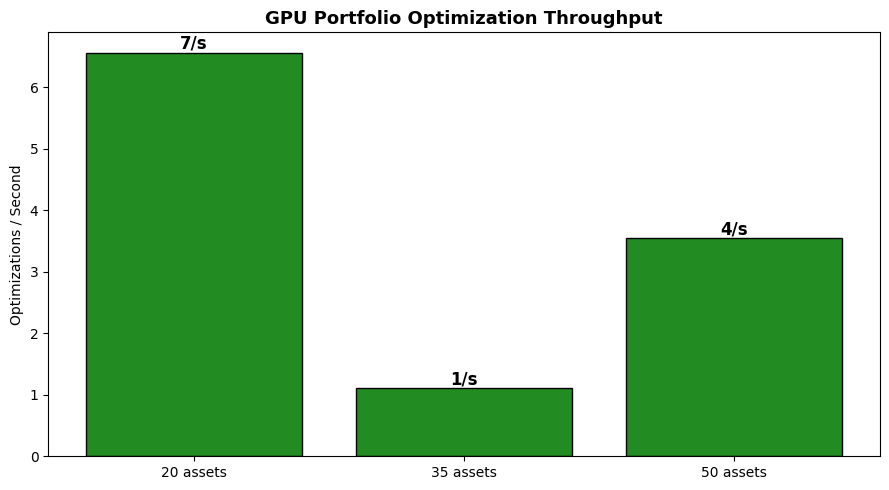


Key insight: At 50 assets, can run 4 optimizations/second
This enables real-time portfolio rebalancing and rapid backtesting.


In [9]:
if len(bench) > 0:
    fig, ax = plt.subplots(figsize=(9, 5))
    throughput = 1000 / bench['mean_ms']
    bars = ax.bar(range(len(bench)), throughput, color='forestgreen', edgecolor='k')
    ax.set_xticks(range(len(bench)))
    ax.set_xticklabels([f"{n} assets" for n in bench['n']])
    ax.set_ylabel('Optimizations / Second')
    ax.set_title('GPU Portfolio Optimization Throughput', fontweight='bold', fontsize=13)
    
    for i, (bar, t) in enumerate(zip(bars, throughput)):
        ax.annotate(f"{t:.0f}/s", (bar.get_x() + bar.get_width()/2, bar.get_height()),
                    ha='center', va='bottom', fontweight='bold', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nKey insight: At 50 assets, can run {throughput.iloc[-1]:.0f} optimizations/second")
    print(f"This enables real-time portfolio rebalancing and rapid backtesting.")

## Summary

This notebook demonstrated:

1. **GPU-accelerated portfolio optimization** with transaction costs
2. **Efficient frontier** computation
3. **Monte Carlo stress testing** with 100 scenarios
4. **Performance benchmarks** showing high throughput

GPU acceleration enables **real-time trading decisions** and **rapid research iteration**.

In [10]:
print("="*55)
print("  PORTFOLIO OPTIMIZATION DEMO COMPLETE")
print("="*55)
print(f"cuProx {cuprox.__version__} | GPU: {cuprox.__cuda_available__}")
print(f"Frontier: {len(frontier)} points computed")
print(f"Stress test: {len(stress['turnover'])} scenarios ({sum(stress['optimal'])} optimal)")
if len(bench) > 0:
    print(f"Peak throughput: {(1000/bench['mean_ms']).max():.0f} optimizations/sec")

  PORTFOLIO OPTIMIZATION DEMO COMPLETE
cuProx 0.1.0 | GPU: True
Frontier: 16 points computed
Stress test: 100 scenarios (98 optimal)
Peak throughput: 7 optimizations/sec
